# 5.1- NLP

NLP trata de aplicaciones que entiendan nuestro idioma, reconocimiento de voz, traducción, comprensión semántica, análisis de sentimiento..

**Usos**

+ Motores de búsqueda
+ Feed de redes sociales
+ Asistentes de voz 
+ Filtros de span
+ Chatbots

**Librerías**

+ NLTK
+ Spacy
+ TFIDF
+ OpenNLP

La dificultad del NLP está en varios niveles:

+ Ambigüedad:

  * Nivel léxico: por ejemplo, varios significados
  * Nivel referencial: anáforas, metáforas, etc...
  * Nivel estructural: la semántica es necesaria para entender la estructura de una oración
  * Nivel pragmático: dobles sentidos, ironía, humor
  
+ Detección de espacios
+ Recepción imperfecta: acentos, -ismos, OCR

El proceso es similar que en USL, primero se vectorizan las palabras y después se miden sus distancias/similitudes. 

In [1]:
# lista de 100 peliculas

titles=open('../data/title_list.txt').read().split('\n')[:100]

titles[:10]

['The Godfather',
 'The Shawshank Redemption',
 "Schindler's List",
 'Raging Bull',
 'Casablanca',
 "One Flew Over the Cuckoo's Nest",
 'Gone with the Wind',
 'Citizen Kane',
 'The Wizard of Oz',
 'Titanic']

In [2]:
synopsis=open('../data/synopses_list.txt').read().split('\n BREAKS HERE')[:100]

synopsis[0][:100]

" Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter's wedding, Vito Corleone h"

### Limpieza

In [3]:
#%pip install spacy

In [4]:
import string

import spacy

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

import re

[nltk_data] Downloading package stopwords to /Users/iudh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#%python -m spacy download en_core_web_sm

#%pip install spacy-lookups-data

In [6]:
nlp=spacy.load('en_core_web_sm')  # inicia el modelo y el parser

parser=English()


# stopwords
stop_words_en=set(stopwords.words('english') + list(STOP_WORDS) + list(nlp.Defaults.stop_words) + ['edit', 'plot'])

stop_words=stop_words_en 

In [7]:
def spacy_tokenizer(sentence):
    
    tokens=parser(sentence)
    
    filtered_tokens=[]

    for word in tokens:
        
        lemma=nlp(str(word))[0].lemma_.lower().strip()
        
        if lemma not in stop_words and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)
            
    return filtered_tokens

In [8]:
%%time

spacy_tokenizer(synopsis[0][:200])

CPU times: user 142 ms, sys: 2.21 ms, total: 144 ms
Wall time: 143 ms


['day',
 'daughter',
 'wedding',
 'vito',
 'corleone',
 'hear',
 'request',
 'role',
 'godfather',
 'new',
 'york',
 'crime',
 'family',
 'vito',
 'young',
 'son']

### TFIDF (term frequency inverse document frequency)

In [9]:
type(synopsis[0])

str

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
tfidf=TfidfVectorizer(min_df=0.15, tokenizer=spacy_tokenizer)

In [12]:
%%time

tfidf_matrix=tfidf.fit_transform(synopsis)

CPU times: user 8min 18s, sys: 1.16 s, total: 8min 19s
Wall time: 8min 20s


In [13]:
tfidf_matrix.shape, len(synopsis)

((100, 282), 100)

In [14]:
(str(tfidf_matrix[0]).split('\n'))

['  (0, 266)\t0.05206640187443229',
 '  (0, 126)\t0.06844490558514539',
 '  (0, 55)\t0.06468771446820924',
 '  (0, 54)\t0.06587994125864935',
 '  (0, 197)\t0.1396611081616326',
 '  (0, 247)\t0.033600061790167474',
 '  (0, 2)\t0.06713034799301722',
 '  (0, 235)\t0.06587994125864935',
 '  (0, 223)\t0.10272842799310297',
 '  (0, 265)\t0.07129542444573374',
 '  (0, 14)\t0.06844490558514539',
 '  (0, 191)\t0.05206640187443229',
 '  (0, 72)\t0.0441651762300984',
 '  (0, 88)\t0.05278837227301264',
 '  (0, 37)\t0.06713034799301722',
 '  (0, 254)\t0.06713034799301722',
 '  (0, 25)\t0.0698305540808163',
 '  (0, 5)\t0.04692356226182523',
 '  (0, 179)\t0.04751274348097854',
 '  (0, 131)\t0.06587994125864935',
 '  (0, 41)\t0.07129542444573374',
 '  (0, 279)\t0.08528451539853694',
 '  (0, 162)\t0.05278837227301264',
 '  (0, 209)\t0.033600061790167474',
 '  (0, 196)\t0.11887838236595735',
 '  :\t:',
 '  (0, 38)\t0.07129542444573374',
 '  (0, 193)\t0.05508497546372355',
 '  (0, 32)\t0.0463476221973419

In [15]:
import pandas as pd

df=pd.DataFrame(tfidf_matrix)

In [16]:
df.head()

,0
0,"(0, 266)\t0.05206640187443229\n (0, 126)\t0..."
1,"(0, 3)\t0.07409824968985139\n (0, 15)\t0.07..."
2,"(0, 97)\t0.07194205003557466\n (0, 189)\t0...."
3,"(0, 158)\t0.0688946215608032\n (0, 136)\t0...."
4,"(0, 248)\t0.06951530059042972\n (0, 104)\t0..."


In [17]:
terms=tfidf.get_feature_names_out()

terms[:15]

array(['able', 'accept', 'act', 'admit', 'affair', 'agree', 'air',
       'allow', 'american', 'apartment', 'appear', 'approach', 'arm',
       'army', 'arrange'], dtype=object)

In [18]:
# os dejo la kata

tfidf_matrix

<100x282 sparse matrix of type '<class 'numpy.float64'>'
	with 8026 stored elements in Compressed Sparse Row format>

### Distancias

In [19]:
from sklearn.metrics.pairwise import cosine_similarity as cos

In [20]:
distancias=1-cos(tfidf_matrix)

distancias.shape

(100, 100)

In [21]:
pd.DataFrame(distancias).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-4.440892e-16,7.836615e-01,8.628936e-01,7.262800e-01,7.936665e-01,0.885565,0.684944,0.812744,0.790074,0.887325,...,0.711120,0.857228,0.793647,0.842130,0.733387,0.695893,0.839461,0.761026,0.819561,0.845598
1,7.836615e-01,-2.220446e-16,7.385854e-01,8.547462e-01,7.420475e-01,0.770460,0.757496,0.748448,0.758731,0.877479,...,0.736600,0.825821,0.815718,0.864810,0.782152,0.891416,0.872804,0.725770,0.809694,0.888927
2,8.628936e-01,7.385854e-01,-2.220446e-16,8.020638e-01,7.686839e-01,0.797634,0.712213,0.751196,0.807033,0.818888,...,0.839602,0.839393,0.700984,0.799973,0.825983,0.906837,0.859341,0.789025,0.805672,0.816972
3,7.262800e-01,8.547462e-01,8.020638e-01,-2.220446e-16,7.936414e-01,0.795372,0.753999,0.654351,0.826224,0.807900,...,0.824892,0.835981,0.761891,0.738925,0.707461,0.811390,0.795685,0.792365,0.805577,0.840954
4,7.936665e-01,7.420475e-01,7.686839e-01,7.936414e-01,2.220446e-16,0.714740,0.700523,0.787626,0.705765,0.780116,...,0.680011,0.766370,0.736439,0.725145,0.613115,0.711165,0.744841,0.623264,0.640315,0.763427


### Clustering

In [22]:
import warnings
warnings.simplefilter('ignore')

import pylab as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')

import numpy as np

In [23]:
from umap import UMAP

In [24]:
umap=UMAP(n_neighbors=5, random_state=42)

emb=umap.fit_transform(distancias)

In [25]:
emb[:5]

array([[ 3.0928345,  6.5110507],
       [ 2.1543605,  8.153049 ],
       [ 2.2113001, 11.233996 ],
       [ 1.0184655,  5.635347 ],
       [ 1.1221211,  8.377206 ]], dtype=float32)

In [26]:
emb.shape

(100, 2)

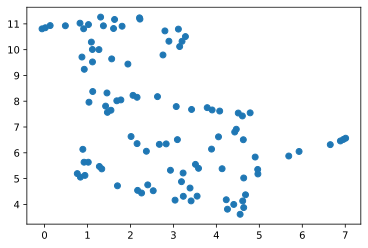

In [27]:
plt.scatter(emb[:, 0], emb[:, 1]);

In [28]:
# DBSCAN

from sklearn.cluster import DBSCAN

In [29]:
dbscan=DBSCAN(eps=0.8, min_samples=7)

In [30]:
dbscan.fit(emb)

DBSCAN(eps=0.8, min_samples=7)

In [31]:
dbscan.labels_

array([-1,  0,  3,  1,  0,  2,  2,  1,  2, -1,  3, -1, -1,  1,  4,  4,  2,
        3,  0,  3, -1,  4,  0,  0,  3,  1, -1,  4,  4,  3,  4,  3,  1,  3,
        3,  1,  3,  5,  3,  1,  2, -1,  2,  2,  2,  2,  2,  2,  3,  5,  3,
        2,  5,  5, -1,  3,  5,  3,  3, -1, -1,  3,  3,  0,  4, -1, -1, -1,
        2,  4,  4,  2,  2,  2,  2,  2,  0,  2,  2,  5, -1,  4,  1,  2,  2,
       -1,  3,  3,  3,  3,  0,  2,  5,  2,  0,  4, -1,  0,  0,  1])

In [32]:
# HDBSCAN

from hdbscan import HDBSCAN

In [33]:
#help(HDBSCAN)

In [34]:
hdbscan=HDBSCAN(min_cluster_size=5)

clusters=hdbscan.fit_predict(emb)

In [35]:
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5])

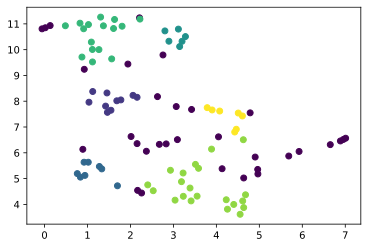

In [36]:
plt.scatter(emb[:, 0], emb[:, 1], c=clusters);

### titulos de los clusters

In [37]:
def get_titles_from_cluster(c):
    return pd.Series(titles)[clusters==c]

In [38]:
get_titles_from_cluster(-1)

0                          The Godfather
2                       Schindler's List
5        One Flew Over the Cuckoo's Nest
8                       The Wizard of Oz
9                                Titanic
11                The Godfather: Part II
12                                Psycho
17                    The Sound of Music
20            E.T. the Extra-Terrestrial
26                 It's a Wonderful Life
30                               Amadeus
35                 From Here to Eternity
41                The Philadelphia Story
43                  An American in Paris
54                         The Apartment
59                            Goodfellas
60                          The Exorcist
63                 The French Connection
65                     The King's Speech
66                 It Happened One Night
67                    A Place in the Sun
68                       Midnight Cowboy
70                              Rain Man
80                        The Green Mile
81    Close Enco

In [39]:
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(), columns=terms)

tfidf_df.head()

,able,accept,act,admit,affair,agree,air,allow,american,apartment,...,win,window,witness,woman,work,world,wound,year,york,young
0,0.0,0.187373,0.06713,0.000000,0.000000,0.046924,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.085285,0.13176,0.046348
1,0.0,0.000000,0.00000,0.074098,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.096655,0.058596,0.0,0.086747,0.00000,0.000000
2,0.0,0.000000,0.00000,0.000000,0.000000,0.050287,0.000000,0.121612,0.000000,0.0,...,0.073351,0.0,0.066935,0.055046,0.000000,0.154342,0.0,0.000000,0.00000,0.000000
3,0.0,0.000000,0.00000,0.000000,0.139079,0.000000,0.069539,0.000000,0.089430,0.0,...,0.130671,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.081410,0.18866,0.000000
4,0.0,0.000000,0.00000,0.000000,0.000000,0.053999,0.000000,0.065295,0.071876,0.0,...,0.000000,0.0,0.000000,0.000000,0.054677,0.000000,0.0,0.000000,0.00000,0.000000


In [40]:
def get_df_from_cluster(c):
    return tfidf_df[clusters==c]

In [41]:
get_df_from_cluster(2).describe()

,able,accept,act,admit,affair,agree,air,allow,american,apartment,...,win,window,witness,woman,work,world,wound,year,york,young
count,6.0,6.000000,6.000000,6.0,6.0,6.000000,6.000000,6.000000,6.000000,6.0,...,6.000000,6.000000,6.000000,6.000000,6.0,6.0,6.000000,6.0,6.0,6.000000
mean,0.0,0.029185,0.017675,0.0,0.0,0.020639,0.012787,0.021557,0.018222,0.0,...,0.012014,0.010194,0.033022,0.012171,0.0,0.0,0.061466,0.0,0.0,0.028064
std,0.0,0.047265,0.043294,0.0,0.0,0.031990,0.031321,0.034894,0.044635,0.0,...,0.029428,0.024969,0.051567,0.029812,0.0,0.0,0.048927,0.0,0.0,0.032038
min,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
25%,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.019415,0.0,0.0,0.000000
50%,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.079708,0.0,0.0,0.019880
75%,0.0,0.049333,0.000000,0.0,0.0,0.045244,0.000000,0.036505,0.000000,0.0,...,0.000000,0.000000,0.066598,0.000000,0.0,0.0,0.098169,0.0,0.0,0.056987
max,0.0,0.109333,0.106048,0.0,0.0,0.063509,0.076722,0.080667,0.109333,0.0,...,0.072083,0.061161,0.109333,0.073025,0.0,0.0,0.105742,0.0,0.0,0.065893


In [42]:
get_df_from_cluster(2).describe().T

,count,mean,std,min,25%,50%,75%,max
able,6.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
accept,6.0,0.029185,0.047265,0.0,0.000000,0.000000,0.049333,0.109333
act,6.0,0.017675,0.043294,0.0,0.000000,0.000000,0.000000,0.106048
admit,6.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
affair,6.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
world,6.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
wound,6.0,0.061466,0.048927,0.0,0.019415,0.079708,0.098169,0.105742
year,6.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
york,6.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [43]:
top_words=get_df_from_cluster(-1).T.sum(axis=1).sort_values(ascending=False)

top_words.head()

george       3.337295
apartment    2.722472
john         2.659868
family       2.438765
father       2.070900
dtype: float64

In [44]:
get_titles_from_cluster(3)

10                                   Lawrence of Arabia
19                                            Star Wars
24                         The Bridge on the River Kwai
29    Dr. Strangelove or: How I Learned to Stop Worr...
31                                       Apocalypse Now
33        The Lord of the Rings: The Return of the King
34                                            Gladiator
36                                  Saving Private Ryan
38                              Raiders of the Lost Ark
48                                               Patton
50                                           Braveheart
55                                              Platoon
57                                   Dances with Wolves
58                                          The Pianist
61                                      The Deer Hunter
62                       All Quiet on the Western Front
dtype: object

## NLP_es 

In [45]:
#!python -m spacy download es_core_news_md

In [46]:
nlp=spacy.load('es_core_news_md')

In [47]:
doc2vec=nlp('hola me llamo pepito').vector.sum()

doc2vec

-17.019897

In [48]:
word2vec=(nlp('hola').vector + nlp('me').vector + nlp('llamo').vector + nlp('pepito').vector).sum()/4

word2vec

-17.0198974609375

##### similitud

In [49]:
nlp('quiero saludar a todos los alumnos de Ironhack, que pasa alegres').similarity(nlp('hola a todos los alumnos'))

0.8309713443074137

In [50]:
token_1=spacy_tokenizer('quiero saludar a todos los alumnos de Ironhack, que pasa alegres')
token_2=spacy_tokenizer('hola a todos los alumnos')

token_1

['querer',
 'saludar',
 'todo',
 'el',
 'alumno',
 'de',
 'ironhack',
 'que',
 'pasar',
 'alegre']

In [51]:
def get_simil(t1, t2):
    return nlp(' '.join(t1)).similarity(nlp(' '.join(t2)))  # similitud es entre -1 y 1, por el valor del coseno

In [52]:
get_simil(token_1, token_2)

0.7221080959132022

# WordClouds

In [53]:
#!pip install langdetect
#!pip install wordcloud

In [54]:
# librerias

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from spacy.lang.es import Spanish



import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words_sp=set(stopwords.words('spanish') + ['haber'])
stop_words_en=set(stopwords.words('english'))

stop_words=stop_words_sp | stop_words_en 


import re

from langdetect import detect

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /Users/iudh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
def tokenizer(frase):
    
    if detect(frase)=='en':  # si esta en ingles...
        nlp=spacy.load('en_core_web_sm')
        parser=English()
        
    elif detect(frase)=='es': # si esta en castellano...
        nlp=spacy.load('es_core_news_md')
        parser=Spanish()
        
    else:
        return 'No es ni castellano ni ingles..'
    
    
    tokens=parser(frase)
    
    clean_tokens=[]
    
    for e in tokens:
        
        lema=nlp(str(e))[0].lemma_.lower().strip()
        
        if lema not in stop_words and re.search('^[a-zA-Z]+$', lema):
            
            clean_tokens.append(lema)
            
    return ' '.join(clean_tokens)

In [56]:
def wordcloud(df, col):
    
    wordcloud=WordCloud(width=1600,
                        height=400,
                        stopwords=stop_words,
                        colormap='Spectral').generate(' '.join([e for e in df[col]]))
    
    plt.figure(figsize=(15, 10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig('images/wordcloud.png', facecolor='k', bbox_inches='tight')
    plt.show();

In [57]:
%%time

df=pd.DataFrame(synopsis, columns=['text'])

df.text=df.text.apply(tokenizer)

df.head()

CPU times: user 9min 2s, sys: 1.95 s, total: 9min 4s
Wall time: 9min 4s


,text
0,plot edit edit edit day daughter wedding vito ...
1,plot edit edit edit banker andy dufresne convi...
2,plot edit edit edit german move polish jews gh...
3,plot edit edit edit brief scene age overweight...
4,plot edit edit edit early december american ex...


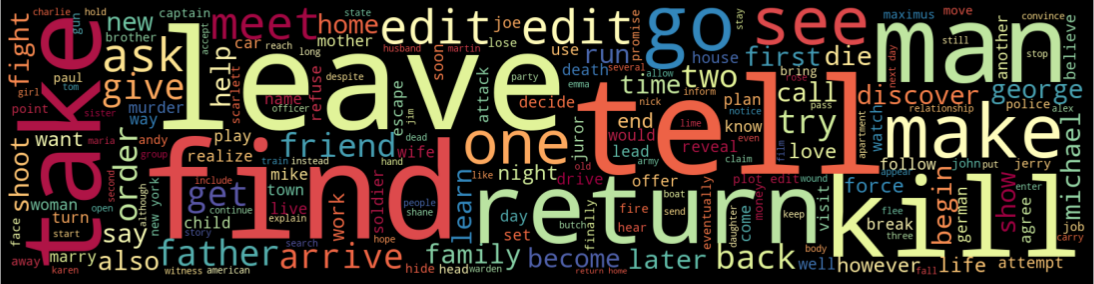

In [58]:
wordcloud(df, 'text')

In [59]:
%%time

txt=open('../data/conde.txt').read().split('\n BREAKS HERE')[:100]

df2=pd.DataFrame(txt, columns=['text'])

df2.text=df2.text.apply(tokenizer)

df2.head()

CPU times: user 30.2 s, sys: 198 ms, total: 30.4 s
Wall time: 30.3 s


,text
0,alejandro conde marsella febrero guarda dar ha...


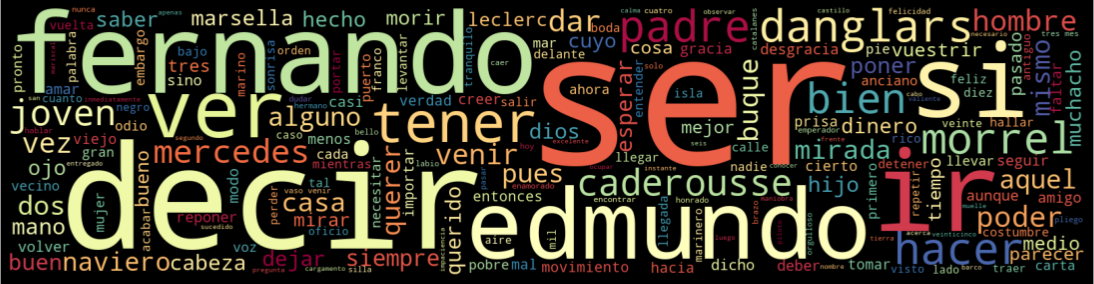

In [60]:
wordcloud(df2, 'text')

In [61]:
#help(WordCloud)

#### Mascara

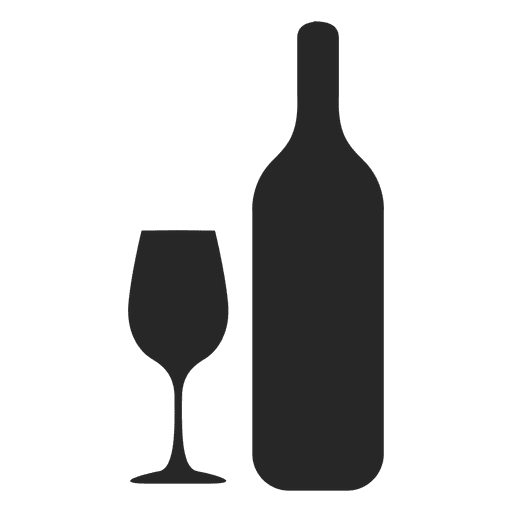

In [62]:
# imagen con mascara

Image.open('images/vino.png')

In [63]:
vino_mask=np.array(Image.open('images/vino.png'))

vino_mask.shape

(512, 512)

In [64]:
# transformacion de la mascara

def transformacion(val):
    if val==0:
        return 255
    else:
        return val

In [65]:
t_vino_mask=np.ndarray((vino_mask.shape[0], vino_mask.shape[1]), np.int32)


for i in range(len(vino_mask)):
    t_vino_mask[i]=list(map(transformacion, vino_mask[i]))

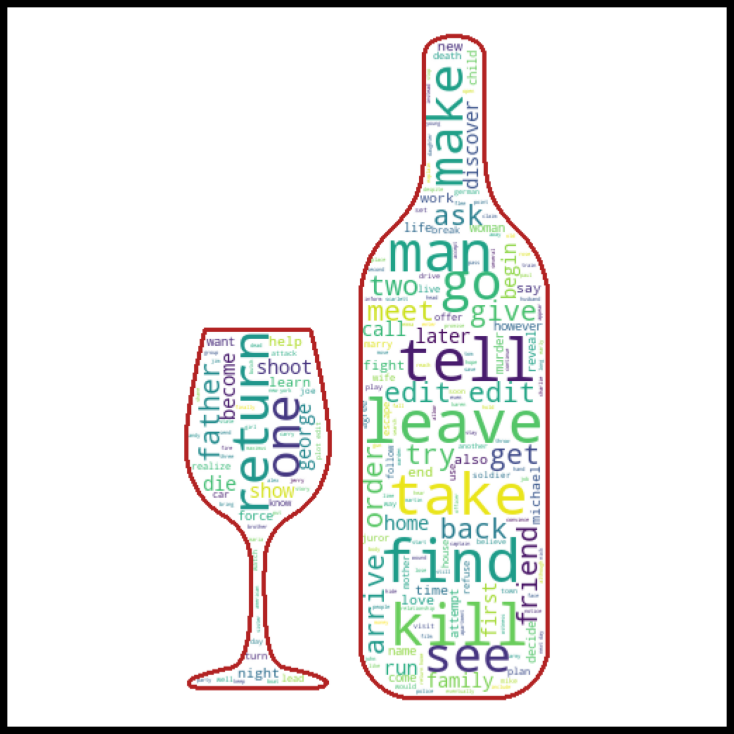

In [66]:
w=WordCloud(background_color='white',
                   max_words=1000,
                   mask=t_vino_mask,
                   stopwords=stop_words,
                   contour_width=3,
                   contour_color='firebrick').generate(' '.join([e for e in df.text]))


w.to_file('images/copa&botella.png')


plt.figure(figsize=(15, 10), facecolor='k')
plt.imshow(w)
plt.axis('off')
plt.tight_layout(pad=0)


### ejemplo con todo

In [67]:
def tokenizer(lst):  # ahora entra una lista
    
    en=0
    es=0
    
    for txt in lst:
        try:
            txt=str(txt)
            if detect(txt)=='en':    # si el texto esta en ingles...
                en+=1
                
                nlp=spacy.load('en_core_web_sm')
                parser=English()
                tokens=parser(txt)

                tokens_en=[]

                for word in tokens:
                    lemma=nlp(str(word))[0].lemma_.lower().strip()
                    if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
                        tokens_en.append(lemma)

            elif detect(txt)=='es':   # si el texto esta en castellano...
                es+=1
                
                nlp=spacy.load('es_core_news_md')
                parser=Spanish()
                tokens=parser(txt)

                tokens_es=[]

                for word in tokens:
                    lemma=nlp(str(word))[0].lemma_.lower().strip()
                    if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
                        tokens_es.append(lemma)

            else:
                print ('No se reconoce idioma (EN / ES)...')
        
        except:
            print ('ERROR...')
            continue
    
    
    return ' '.join(tokens_en), ' '.join(tokens_es), en, es

In [68]:
%%time

mix_txt=synopsis+txt

tokens=tokenizer(mix_txt)

CPU times: user 9min 34s, sys: 1.74 s, total: 9min 35s
Wall time: 9min 35s


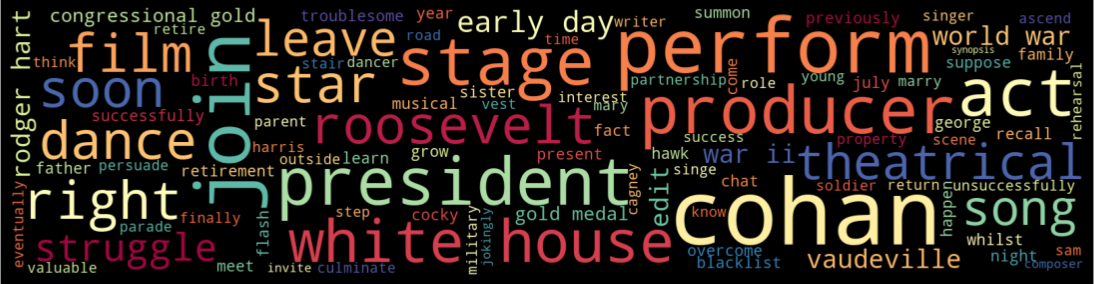

In [69]:
# wordcloud en ingles

serie_en=pd.DataFrame({'en': tokens[0]}, index=[0])

wordcloud(serie_en, 'en')

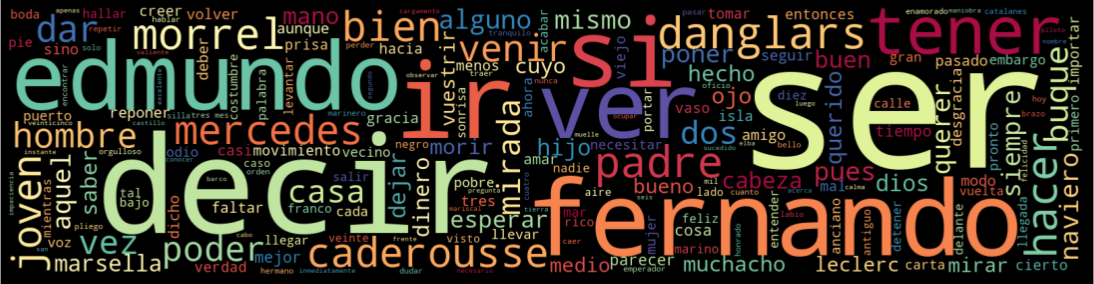

In [70]:
# wordcloud en castellano

serie_es=pd.DataFrame({'es': tokens[1]}, index=[0])

wordcloud(serie_es, 'es')

In [71]:
tokens[2]

100

In [72]:
tokens[3]

1

## NER

In [73]:
news=pd.read_csv('../data/noticias.csv')

news.head()

,url,authors,title,publish_date,text,top_image,keywords,summary,video,polarity,subjectivity,negativity,neutrality,positivity,compound_score
0,http://epaper.lavanguardia.com/la-vanguardia/l...,[],14 de agosto de 2020,2020-08-14 00:00:00,"Segunda\n\nTodo sobre Kamala Harris En 1970, c...",http://static.milibris.com/thumbnail/issue/9d8...,"[""14"", ""2020"", ""agosto""]",Postal: ciudad zombi La preocupación por la ag...,[],0.031507,0.381115,0.020,0.960,0.021,-0.1048
1,http://epaper.lavanguardia.com/la-vanguardia/l...,[],13 de septiembre de 2020,2020-09-13 00:00:00,Segunda\n\nEl papel no quiere morir Una notici...,http://static.milibris.com/thumbnail/issue/876...,"[""septiembre"", ""2020"", ""13""]",El honor de la familia se ha desplazado del vi...,[],0.090058,0.451170,0.025,0.955,0.020,-0.9705
2,http://epaper.lavanguardia.com/la-vanguardia/l...,[],15 de julio de 2020,2020-07-15 00:00:00,Segunda\n\nPrivacidad en peligro Existe una em...,http://static.milibris.com/thumbnail/issue/cce...,"[""julio"", ""2020"", ""15""]",Los estudiantes internacionales matriculados e...,[],0.076812,0.416667,0.025,0.957,0.018,-0.9798
3,https://club.lavanguardia.com/es/ocio-cultura/...,[],Descuento PortAventura,NaN,Presenta tu tarjeta del Club en taquillas\n\n3...,https://club.lavanguardia.com/sites/default/fi...,"[""world"", ""descuento"", ""portaventura"", ""tarjeta""]",Presenta tu tarjeta del Club en taquillas35% d...,"[""https://www.youtube.com/embed/oqXl8CLaHdY""]",0.100000,0.100000,0.040,0.960,0.000,-0.7783
4,http://epaper.lavanguardia.com/la-vanguardia/l...,[],1 de febrero de 2021,2021-02-01 00:00:00,Portada\n\nSalut defiende prolongar las restri...,http://static.milibris.com/thumbnail/issue/d7c...,"[""febrero"", ""2021""]",Sostiene que el PP genera progreso allí donde ...,[],0.057292,0.425556,0.021,0.957,0.022,-0.5686


In [74]:
news.tail(2).T

,1393,1394
url,https://www.estrategiasdeinversion.com/analisi...,https://www.estrategiasdeinversion.com/analisi...
authors,"[""Redacci\u00f3n"", ""Estrategias De Inversi\u00...","[""Lara Cucurull""]"
title,Trading en vivo: cómo aprovechar las oportunid...,"""La euforia en el psicotrading es algo muy com..."
publish_date,NaN,NaN
text,9:00 - 9.50 IDEAS DE TRADING: METODOLOGÍA Y HE...,-La gestión de las emociones es fundamental pa...
top_image,https://www.estrategiasdeinversion.com/uploads...,https://www.estrategiasdeinversion.com/uploads...
keywords,"[""analista"", ""vivo"", ""inversi\u00f3n"", ""produc...","[""euforia"", ""emociones"", ""complicado"", ""psicot..."
summary,9:00 - 9.50 IDEAS DE TRADING: METODOLOGÍA Y HE...,La tercera es la automotivación y dentro está ...
video,"[""https://www.youtube.com/embed/-2axYm4JsCg""]",[]
polarity,0.025,0.0


In [75]:
import spacy
from spacy import displacy

In [76]:
#!python -m spacy download es_core_news_lg

In [77]:
#!python -m spacy download en_core_web_lg

In [78]:
spacy_core_es='es_core_news_md'

spacy_core_en='en_core_web_sm'

In [79]:
def ner(spacy_core, data):
    
    nlp=spacy.load(spacy_core)
    
    frases=list(nlp(data).sents)  # frases, sentencias
    
    entidades=displacy.render(nlp(str(frases)), style='ent')
    
    return entidades

In [80]:
ner(spacy_core_es, news.text[150])

In [81]:
ner(spacy_core_en, synopsis[3][:1000])

### Transformers (creacion de texto)

In [82]:
#!pip install transformers
#!pip install torch

In [83]:
from transformers import pipeline

generador=pipeline('text-generation', 
                   model='EleutherAI/gpt-neo-125M')

In [84]:
def crea_texto(generador, texto, min_long=20):
    
    return generador(texto, do_sample=True, min_length=min_long)[0]['generated_text']

In [85]:
crea_texto(generador, 'data science is')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'data science is not designed to work only on the properties of the world. We are using the data'

In [86]:
crea_texto(generador, 'what planet is this')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'what planet is this?  How can I find out whether the planet is a true geologic sphere'

In [87]:
crea_texto(generador, 'humans are')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'humans are not immune to negative pressure. One such example is a case in which a student of medicine'

In [88]:
crea_texto(generador, 'el monstruo de las galletas')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'el monstruo de las galletas, y la cual nunca tuvieron la'

In [89]:
crea_texto(generador, 'molt be noi')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'molt be noi og ægning om, at nye eksemp'

In [90]:
crea_texto(generador, 'rellampagos asgaya')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'rellampagos asgaya.\n\nOn May 14, 2014, the Russian Air Force on'

In [91]:
crea_texto(generador, 'humans are')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'humans are not born with the same social and emotional patterns as male mammals are, so there is no'

In [92]:
#help(generador)

In [116]:
crea_texto(generador, 'nqeo wberugio hui')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'nqeo wberugio hui bajtom, dať jst'